In [4]:
import os.path

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as imbPipeline
import xgboost as xgb
from lightgbm import LGBMClassifier

# Input the data

## load dataset

In [5]:
file_path = Path('../data/Diabetes_EDA_Kaggle/diabetes_prediction_dataset.csv')

if not os.path.exists(file_path):
    raise FileExistsError(f"Directory {file_path} does not exist")

df = pd.read_csv(file_path)

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## handling duplicates

In [8]:
duplicate_rows_data = df[df.duplicated()]
print("quantity of duplicate rows: ", duplicate_rows_data.shape)

quantity of duplicate rows:  (3854, 9)


## delete duplicates

In [9]:
df = df.drop_duplicates()
df.shape

(96146, 9)

## Uniqueness

In [10]:
for column in df.columns:
    unique_value = len(df[column].unique())
    print(f"{column}: {unique_value} quantity unique value")

gender: 3 quantity unique value
age: 102 quantity unique value
hypertension: 2 quantity unique value
heart_disease: 2 quantity unique value
smoking_history: 6 quantity unique value
bmi: 4247 quantity unique value
HbA1c_level: 18 quantity unique value
blood_glucose_level: 18 quantity unique value
diabetes: 2 quantity unique value


## missing values

In [11]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## Remove Unneccessary value

In [6]:
df = df[df['gender'] != 'Other']
df.shape

(99982, 9)

## Describe the Data

In [13]:
df.describe().style.format('{:.2f}')

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


# Visualisation

## Histogram for age

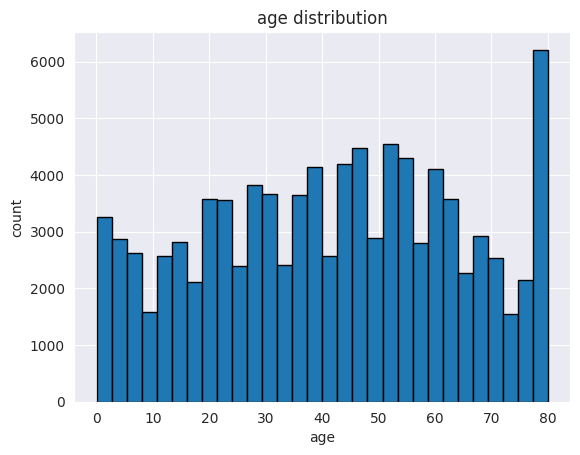

In [14]:
plt.hist(df['age'], bins=30, edgecolor='black')
# bins=30 in plt.hist(...) means that the histogram will be split into 30 "bins" (columns).
# Each bin is a range of age values, for example:
# 1 bin: 0 to 3 years,
# 2 bin: 3 to 6 years,ng
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

## Bar plot for gender

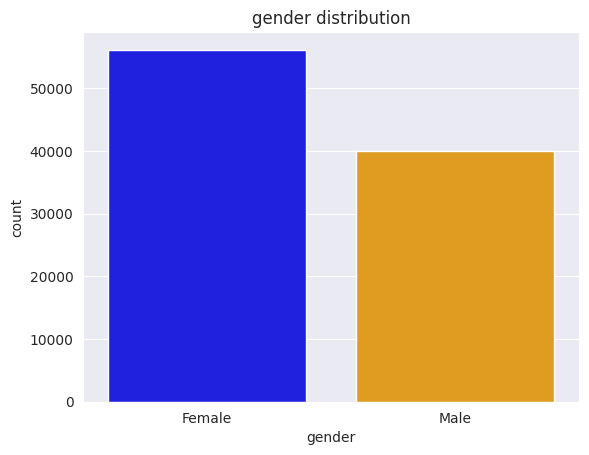

In [15]:
sns.countplot(x='gender', data=df, hue='gender', palette=['blue', 'orange'])
plt.title('gender distribution')
plt.show()

## Distribution plot for BMI

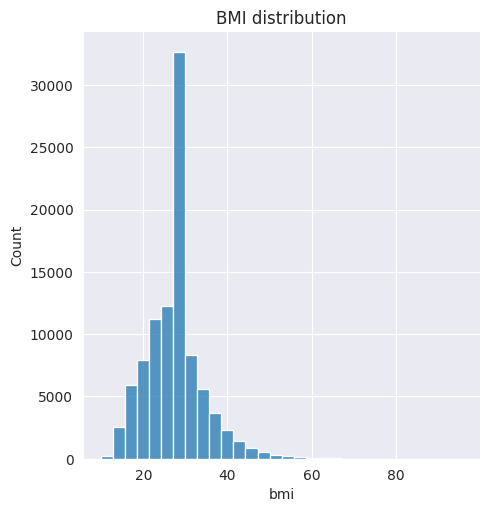

In [16]:
sns.displot(df['bmi'], bins=30)  # there is KDE here (smooth density curve)
plt.title('BMI distribution')
plt.show()

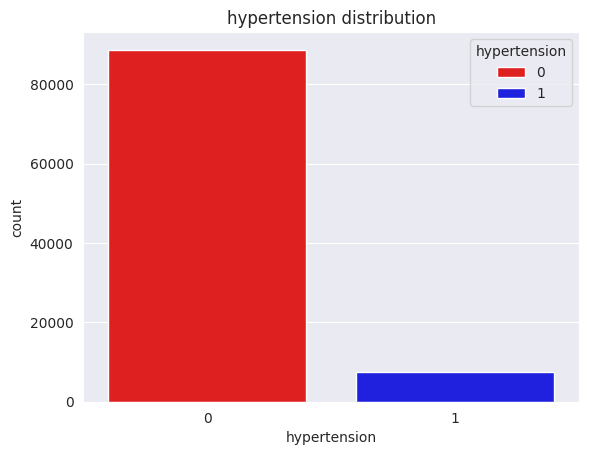

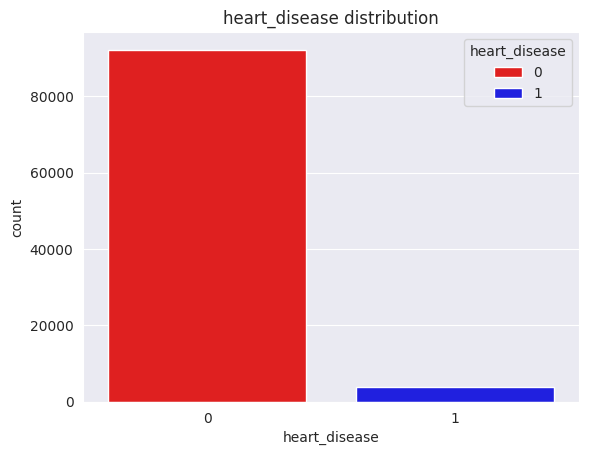

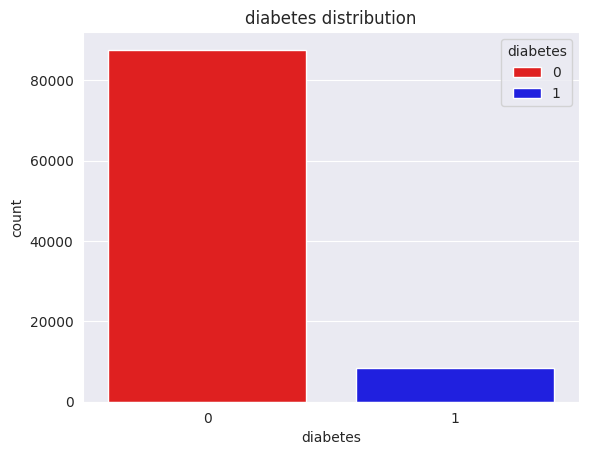

In [17]:
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df, hue=col, palette=['red', 'blue'])
    plt.title(f'{col} distribution')
    plt.show()
# If 0/1 is just a column in features (X), sampling is NOT NEEDED.

## Count plot of hypertension vs diabetes

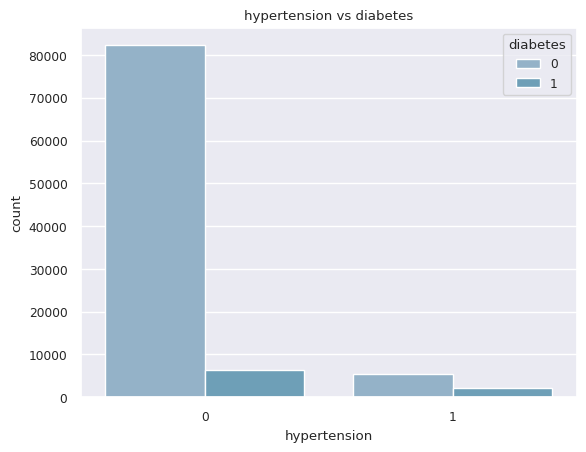

In [176]:
sns.countplot(data=df, x='hypertension', hue='diabetes')
plt.title('hypertension vs diabetes')
plt.show()

## Count plot of heart_disease vs diabetes

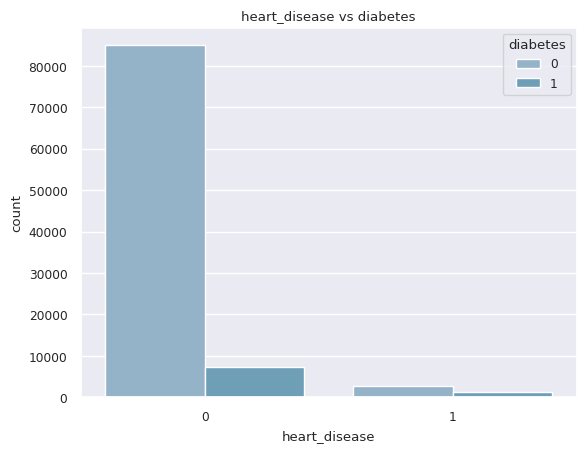

In [178]:
sns.countplot(data=df, x='heart_disease', hue='diabetes')
plt.title('heart_disease vs diabetes')
plt.show()

## Count plot for smoking history

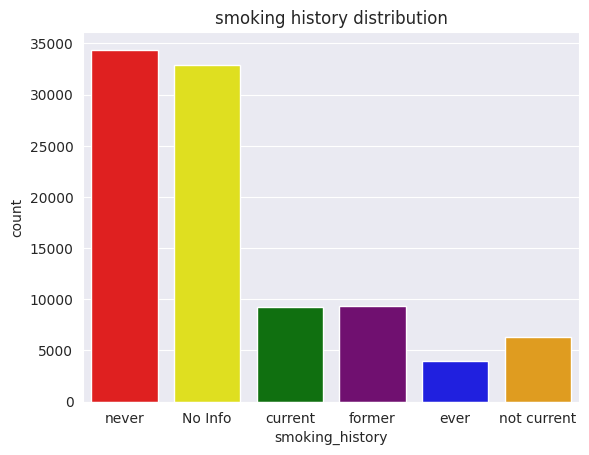

In [18]:
sns.countplot(x='smoking_history', data=df, hue='smoking_history',
              palette=['red', 'yellow', 'green', 'purple', 'blue', 'orange'])
plt.title('smoking history distribution')
plt.show()

## Boxplot BMI vs Diabetes classification

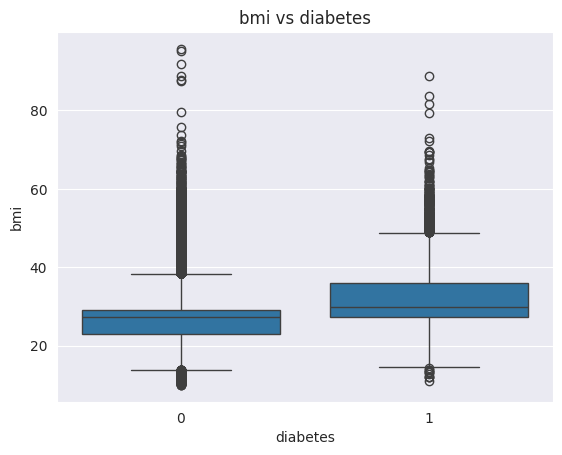

In [19]:
sns.boxplot(x='diabetes', y='bmi',
            data=df)  # graph shows how BMI (body mass index) is related to the presence of diabetes
plt.title('bmi vs diabetes')
plt.show()

## Boxplot Age vs Diabetes classification

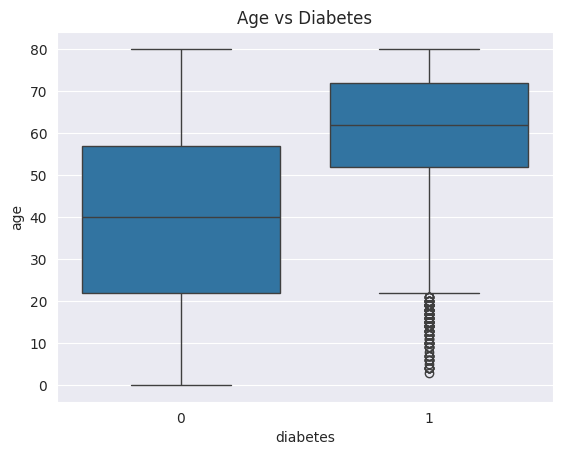

In [20]:
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

## Count plot of gender vs diabetes

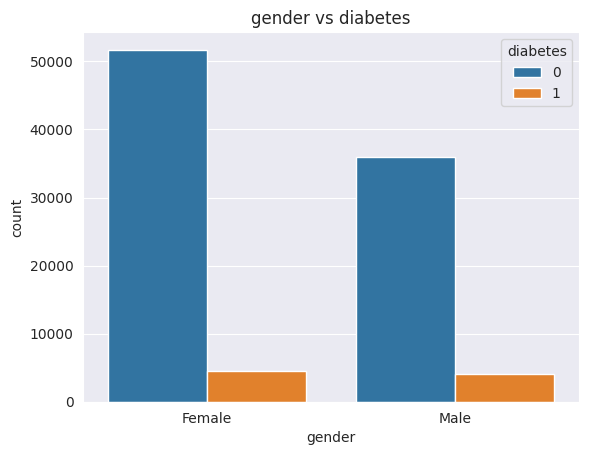

In [21]:
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('gender vs diabetes')
plt.show()

# Boxplot HbA1c level vs Diabetes classification

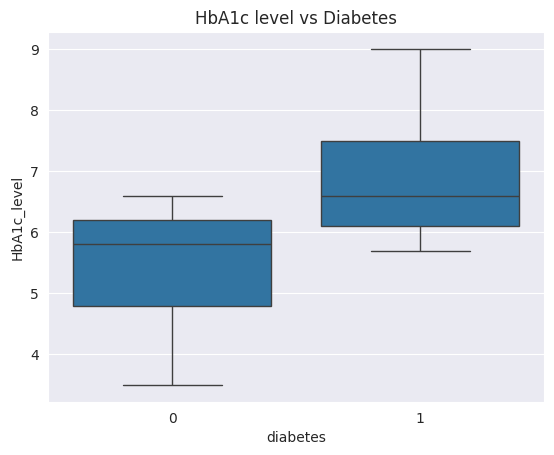

In [22]:
sns.boxplot(x='diabetes', y="HbA1c_level", data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()

## Boxplot blood glucose level vs Diabetes classification

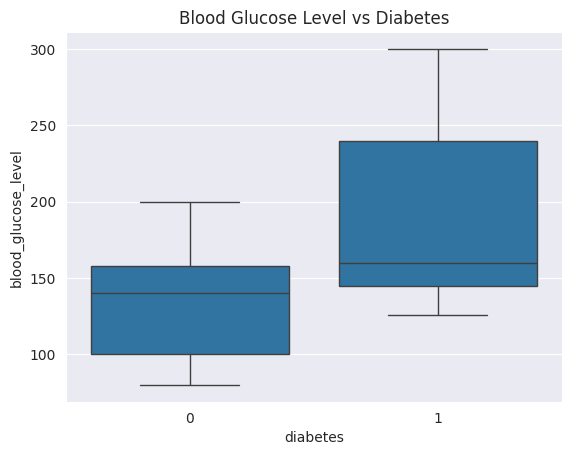

In [23]:
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()
plt.show()

## Pair plot for numeric features

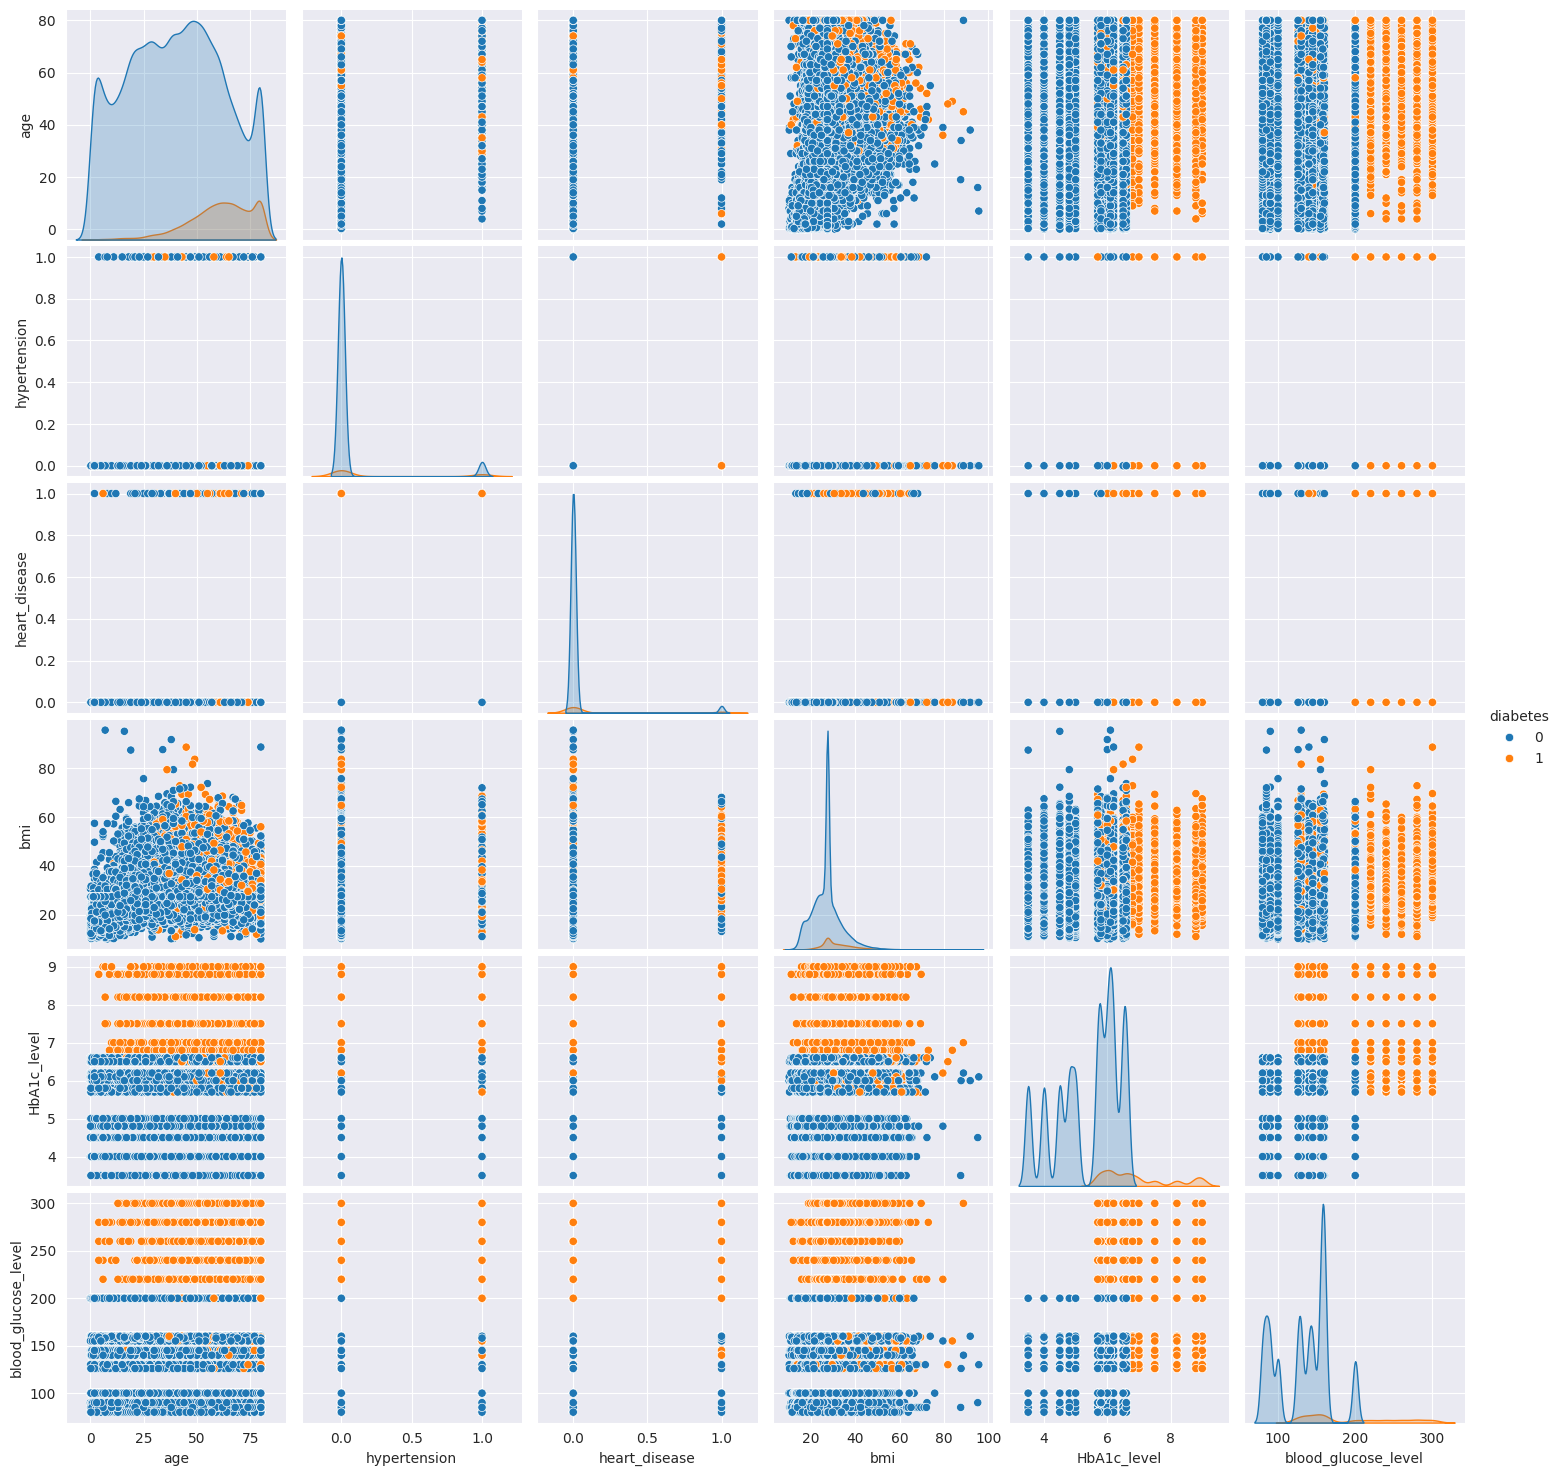

In [24]:
sns.pairplot(df, hue='diabetes')
plt.show()
# for example:
# 🔴 — diabetes positive (1),
# 🔵 — diabetes negative (0).
# It is clear which signs correlate with each other.

## Scatterplot Age vs BMI colored by Diabetes classification

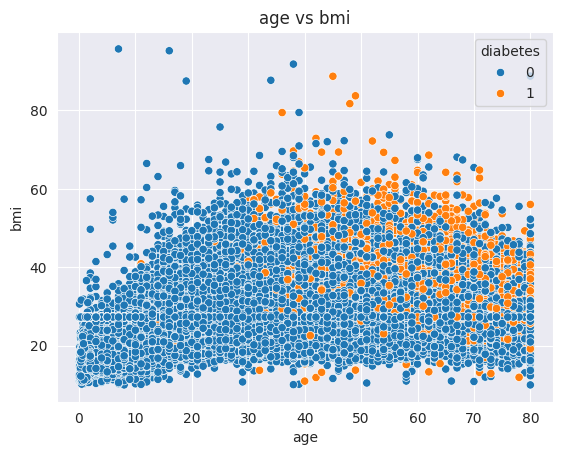

In [25]:
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('age vs bmi')
plt.show()

## Violin plot of BMI against diabetes classification split by gender

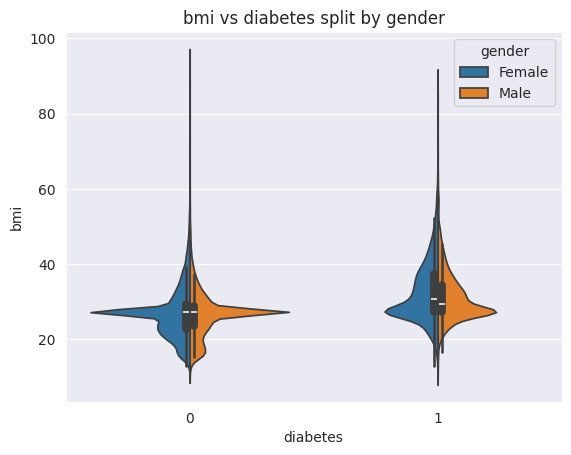

In [26]:
sns.violinplot(x='diabetes', y='bmi', hue='gender', split=True, data=df)
plt.title('bmi vs diabetes split by gender')
plt.show()
# violinplot shows the distribution of BMI in people with and without diabetes, divided by gender.
# The small vertical bar in the center is the median (the average BMI for the group).
# The thick gray bar (box) is the range where 50% of the data is (from the 25th to the 75th percentile).
# The thin lines (whiskers) are the extreme values of the data, excluding outliers.

# how to read part of violin:
# Width = how many people have that BMI.
# The wider the part, the more people have that value.
# Narrow parts are rare values.

##  Interaction between gender, BMI and diabetes

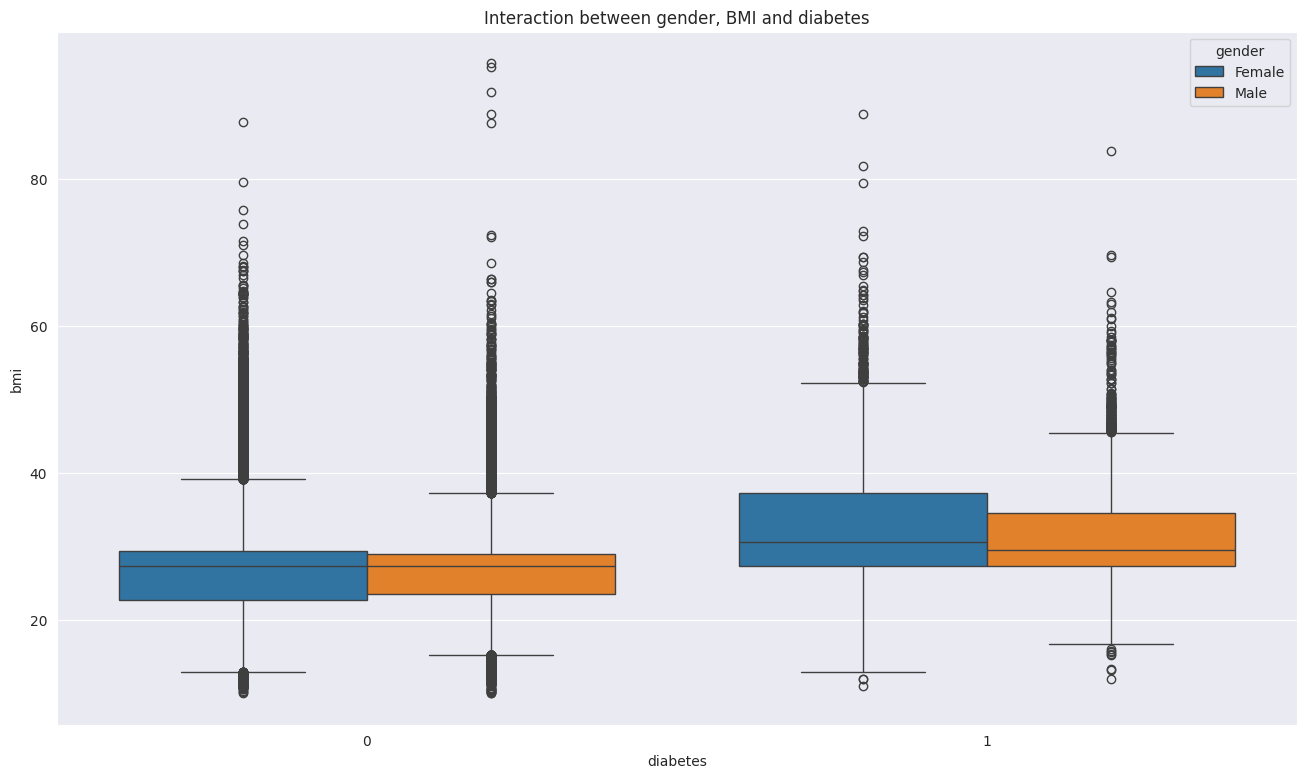

In [27]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df)
plt.title('Interaction between gender, BMI and diabetes')
plt.show()

## Interaction between gender, Age and diabetes

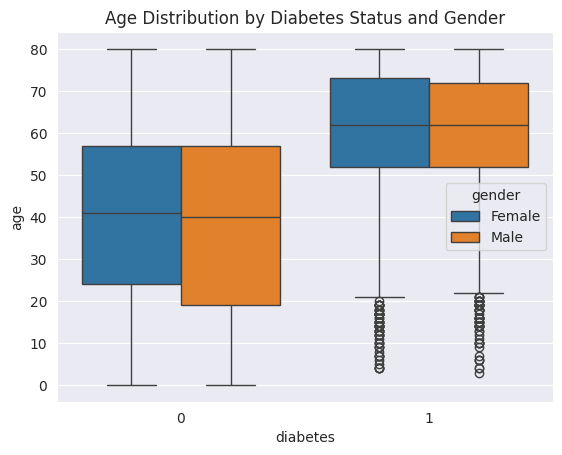

In [28]:
sns.boxplot(x='diabetes', y='age', hue='gender', data=df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

# Data preparation

In [7]:
def recategorize_smoking(smoking_status):
    match smoking_status:
        case 'never' | 'No Info':
            return 'non-smoker'
        case 'current':
            return 'current'
        case 'ever' | 'former' | 'not current':
            return 'pass_smoker'
        case _:
            raise ValueError(f"Unexpected smoking status: {smoking_status}")


df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)
# The .apply() method in Pandas applies to each element of a column or row, executing the specified function for each value.
# apply() will call the recategorize_smoking function for each value in the column and return the result in a new column.
# When you write .apply(recategorize_smoking), you are not calling the function directly, but passing a reference to the function so that it can be applied to all in the column.

In [9]:
data = df.copy()

## Encoding

In [10]:
# perform_one_hot_encoding - for analysis, graphics
# OneHotEncoder - In Pipeline, for ML models, cross-validation
def perform_one_hot_encoding(data_frame, column_name):
    dummmies = pd.get_dummies(data_frame[column_name], prefix=column_name)
    # pd.get_dummies(df[column_name]) is a pandas method that turns categorical values in column_name into a set of binary (0 or 1) columns.
    # prefix=column_name adds a prefix to the names of the new columns so that they are identifiable (e.g. if the column is called gender, the new columns will be named gender_male, gender_female)
    return pd.concat([data_frame.drop(column_name, axis=1), dummmies], axis=1)


# pd.concat([df.drop(column_name, axis=1), dummies], axis=1) — concatenates the dataframe without the original column with new binary columns (dummy variables), adding them horizontally (axis=1).

data = perform_one_hot_encoding(data, 'gender')

data = perform_one_hot_encoding(data, 'smoking_history')

## Correlation Matrix

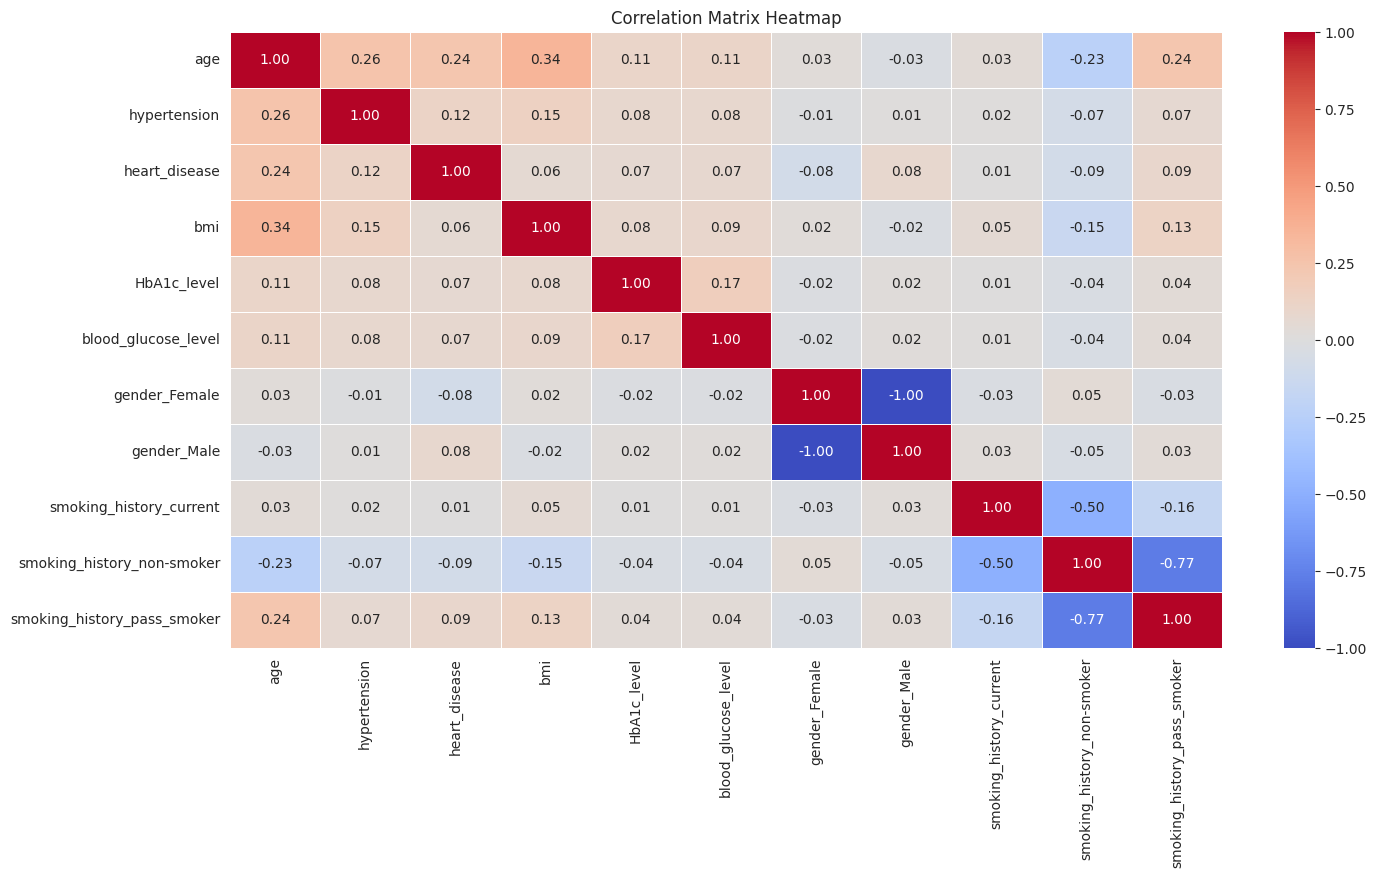

In [32]:
# Compute the correlation matrix

#Graph I.
plt.figure(figsize=(16, 8))
sns.heatmap(data.drop(columns=['diabetes']).corr(), cmap='coolwarm', annot=True, linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

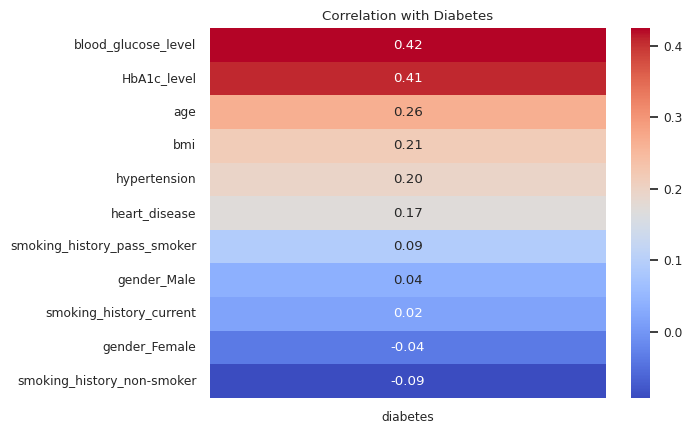

In [33]:
# Graph II
# Create a heatmap of the correlations with the target column
correlation_matrix2 = data.corr()
target_corr = (correlation_matrix2['diabetes'].drop('diabetes'))

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.set_theme(font_scale=0.8)
sns.set_style('darkgrid')
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap='coolwarm', annot=True, fmt='.2f')
# target_corr_sorted is a Series, and sns.heatmap() expects a table (DataFrame), even if it is a single-column one, so we need to turn the Series into a DataFrame
plt.title('Correlation with Diabetes')
plt.show()

# PREDICTIVE ANALYSIS

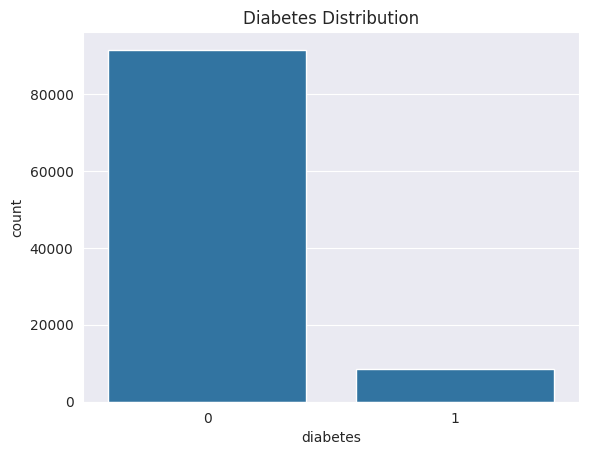

In [11]:
"""
From the EDA ,the dataset is imbalanced (with 9% positive cases for diabetes and 91% negative cases), it's essential to balance the data to ensure that the model doesn't get biased towards the majority class. For this purpose, the Synthetic Minority Over-sampling Technique (SMOTE) is used, which generates synthetic samples for the minority class.
"""
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [12]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
# SMOTE - adds new artificial examples of the rare class (in our case - sick)
# sampling_strategy=0.1 - This means that after SMOTE, the rare class (diabetes) will be 10% of the total. (for example: Was: 950 (healthy) and 50 (sick) and will become: Approximately 105 sick and 950 healthy)
under = RandomUnderSampler(sampling_strategy=0.5)
# RandomUnderSampler - removes examples of the frequent class (healthy) to balance the classes.
# this sounds like: "leave 2 times more healthy than sick". We have 105 sick, so we leave: 105 × 2 = 210 healthy. That is, 750 healthy will be removed randomly.


# Why not just use SMOTE?
# 1. Too much artificial data. 50 real patients, and you want to make 950 - this means that more than 94% will be artificial.
# 2. Not enough diversity in the input data. If there are only 50 real examples, then even SMOTE will not be able to come up with truly diverse new ones.
# 3. Long training and high complexity. Generating a large amount of data requires more resources.

## Define preprocessor

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),
         ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('bin', 'passthrough', ['hypertension', 'heart_disease']),
        ('cat', OneHotEncoder(), ['gender', 'smoking_history'])

    ]
)

# Numeric (age, BMI) StandardScaler
# Binary (0/1, list_of_categories) passthrough
# Categorical (strings or multiple categories) OneHotEncoder

# ColumnTransformer is used to apply different types of processing to different features.
# It is a "preprocessor" that processes numeric and categorical features separately:
# StandardScaler() — normalizes numeric features (makes mean = 0, std = 1).
# OneHotEncoder() — converts categorical features (strings) to numbers (one-hot: 0/1).

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

### Check data after Smote and RandomUnderSampler

In [14]:
pipeline_check = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
])

X_resampled_over_check, y_resampled_over_check = pipeline_check.fit_resample(X, y)

print("New class distribution:", Counter(y_resampled_over_check))

New class distribution: Counter({0: 18296, 1: 9148})


### Visual-on types of diabetes

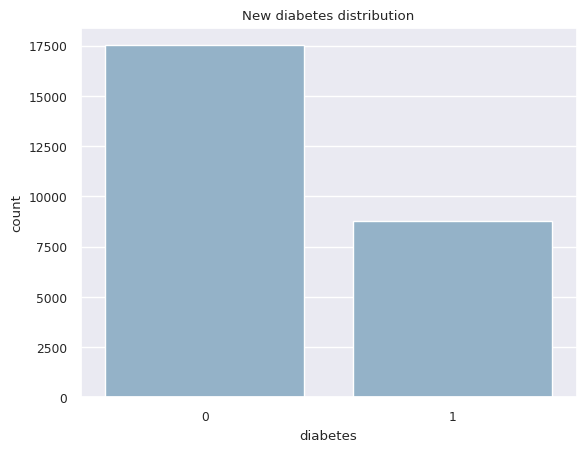

In [196]:
data_check = pd.DataFrame(y_resampled_over_check)

sns.countplot(x='diabetes', data=data_check)
plt.title('New diabetes distribution')
plt.show()

## Create Pipeline

### RFC

In [197]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', RandomForestClassifier())
])

In [199]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [200]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

print('Best parameters', grid_search.best_params_)

Best parameters {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [40]:
# max_depth = 10
# This is the maximum depth of the decision tree.
# That is, how many times the tree can "ask questions" to come to a conclusion.
# If the tree is too deep → it can remember the data and overfit.
# If it is too shallow → it will not understand the pattern.
# 10 is the "golden mean".

# min_samples_leaf = 4
# if you specify 1, then the logic will be based on only 1 person, this is too dangerous - what if it's just a coincidence or a mistake?
# And if min_samples_leaf = 2: Now the tree will say: "I will not make a conclusion (i.e. create a 'leaf') if there is only 1 person in this group. I need at least 2 for me to be sure."
# Why is this?
# 1. This is protection against overfitting - so that the model does not learn from noise or mistakes.
# 2. The higher the value, the rougher and more general the rules will be (the model is more stable, but may lose accuracy).

# min_samples_split = 2
# A tree node (internal "branch") can split if it has at least 2 samples.
# If you set more (for example 10), the tree will split less often.
# Helps control tree growth.
# 2 is the base value, you can split often.
# Let's say in some part of the tree there were:
# 5 rows of data → with min_samples_split = 10 - can't split (too few).
# 12 rows of data → can split.

# n_estimators = 50
# This is the number of trees in the forest (Random Forest = many trees).
# Too many - takes a long time.
# Too few - can be unstable.

## Convert GridSearchCV results to a DataFrame and plot

In [201]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.300343,0.017115,0.030876,0.001364,10,1,2,50,"{'classifier__max_depth': 10, 'classifier__min...",0.951434,0.945387,0.949545,0.951691,0.950715,0.949754,0.002307,26
1,0.517190,0.019097,0.051682,0.001532,10,1,2,100,"{'classifier__max_depth': 10, 'classifier__min...",0.947988,0.951434,0.951235,0.953771,0.950845,0.951055,0.001844,15
2,0.942471,0.028308,0.098828,0.003670,10,1,2,200,"{'classifier__max_depth': 10, 'classifier__min...",0.952149,0.946427,0.947399,0.954226,0.952536,0.950547,0.003064,22
3,0.285873,0.004679,0.028666,0.001125,10,1,5,50,"{'classifier__max_depth': 10, 'classifier__min...",0.948313,0.943047,0.948895,0.952991,0.949610,0.948571,0.003203,27
4,0.531018,0.016262,0.052373,0.000905,10,1,5,100,"{'classifier__max_depth': 10, 'classifier__min...",0.950263,0.948833,0.949480,0.953446,0.951105,0.950625,0.001603,19
5,0.976075,0.038302,0.101909,0.002143,10,1,5,200,"{'classifier__max_depth': 10, 'classifier__min...",0.949548,0.947858,0.949545,0.955657,0.949350,0.950391,0.002708,23
6,0.296744,0.000751,0.030051,0.000796,10,1,10,50,"{'classifier__max_depth': 10, 'classifier__min...",0.952994,0.948313,0.955787,0.954096,0.950195,0.952277,0.002690,2
7,0.525212,0.004208,0.058579,0.008805,10,1,10,100,"{'classifier__max_depth': 10, 'classifier__min...",0.951629,0.945777,0.949480,0.954876,0.951235,0.950600,0.002975,20
8,0.991115,0.011126,0.106138,0.005880,10,1,10,200,"{'classifier__max_depth': 10, 'classifier__min...",0.951889,0.951239,0.950910,0.950455,0.950130,0.950925,0.000613,16
9,0.318129,0.009258,0.031791,0.002846,10,2,2,50,"{'classifier__max_depth': 10, 'classifier__min...",0.950783,0.950133,0.951821,0.954031,0.951886,0.951731,0.001325,6


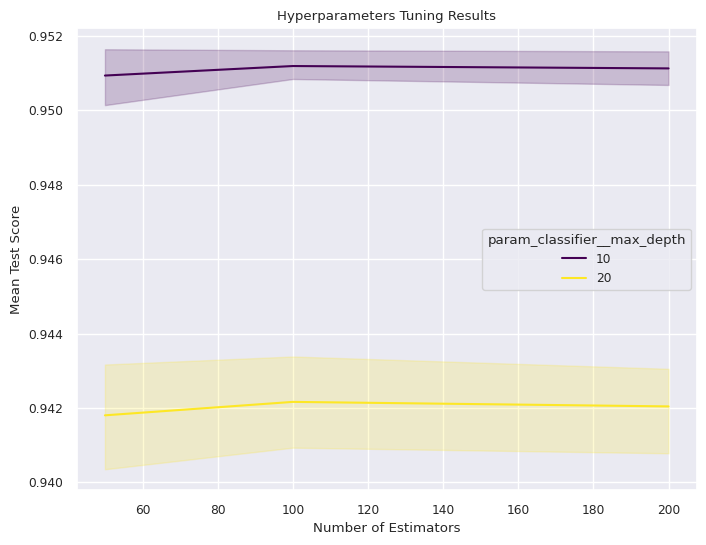

In [202]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score',
             hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

# y='mean_test_score'
# Along the Y axis is the average accuracy (mean_test_score) during validation.
# That is, how well the model works with each set of parameters.

# x='param_classifier__n_estimators'
# Along the X axis is how many trees (n_estimators) are in the forest.
# This is the parameter we selected in Grid Search.

# hue='param_classifier__max_depth'
# Each line on the graph is its own tree depth value (max_depth).
# For example, one line is for depth 5, another is for 10, etc.

# Predict and evaluate

In [43]:
# Precision TP / (TP + FP)- The model said that 10 people are sick, but only 7 are actually sick → accuracy = 70%.
# Recall TP / (TP + FN) - For example: If 10 people are sick, and the model found only 7 → completeness = 70%.
# F1-score 2 * (P * R) / (P + R) - Balance between Precision and Recall. It's good when both precision and recall are important.
# support - it is simply the number of true examples of each class in the test data.

# TP (True Positive) - the model said "sick", and he really is sick ✅
# FP (False Positive) - the model said "sick", but he is healthy ❌
# FN (False Negative) - the model said "healthy", but he is sick ❌
# TN (True Negative) - the model said "healthy", and he is healthy ✅

In [203]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# accuracy_score - Percentage of correct predictions out of all.
# Example:
# Out of 100 patients, the model correctly identified 90 → accuracy = 0.90 (90%)
# TP + TN / TP + TN + FP + FN

# classification_report - Detailed report with metrics:
# Precision (accuracy)
# Recall (recall)
# F1-score (average between them)
# Support (number of examples per class)
#
# confusion_matrix - A table that shows:
# How many were correctly predicted
# How many were incorrect (for example, patients were called healthy and vice versa)

Model accuracy:  0.9498075522729637
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17525
           1       0.69      0.79      0.74      1701

    accuracy                           0.95     19226
   macro avg       0.83      0.88      0.85     19226
weighted avg       0.95      0.95      0.95     19226



## Plot confusion matrix

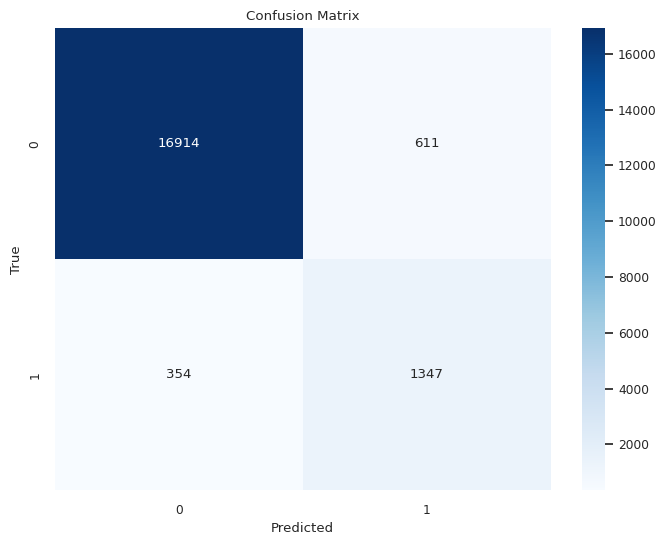

In [204]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Predicted
#  0   1
# [TN FP]
# [FN TP]

## Feature Importance

                        Feature  Importance
2                   HbA1c_level    0.437999
3           blood_glucose_level    0.321890
0                           age    0.125476
1                           BMI    0.059253
4                 gender_Female    0.028551
5                   gender_Male    0.016573
10                heart_disease    0.003219
9                  hypertension    0.002888
7    smoking_history_non-smoker    0.001789
6       smoking_history_current    0.001682
8   smoking_history_pass_smoker    0.000681


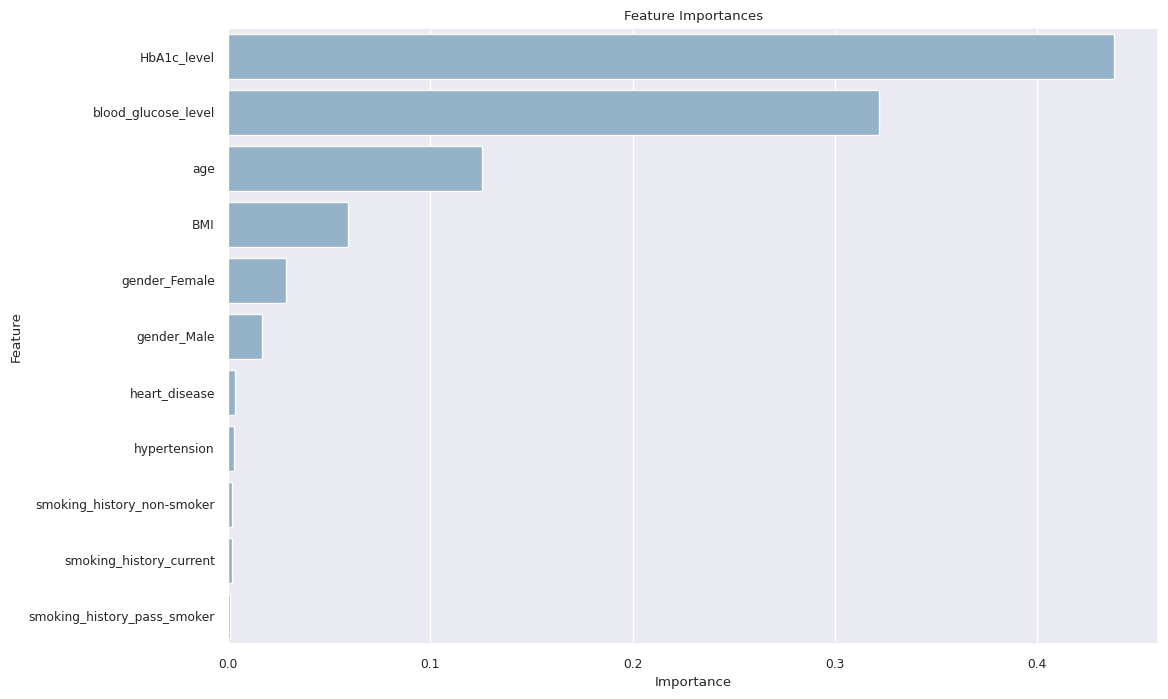

In [205]:
# After fitting the model, we input feature names
onehot_columns = list(
    grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender',
                                                                                                              'smoking_history']))  # We transform text features (gender, smoking history) into numbers (0/1) and get their names.

# WE NEEDN'T USE FOR BIN COLUMNS LIKE IN onehot_columns, because 'bin' is a passthrough, not a transformer.
# And passthrough doesn't have a .get_feature_names_out() method, because it doesn't change anything, it just passes the data as is. So we should do like this:
bin_columns = ['hypertension', 'heart_disease']

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level'] + onehot_columns + bin_columns

# And now let's get the feature importances
importance = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

### DTC

In [25]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [26]:
param_grid = {
    # How many minimum examples are needed for a node to split
    'classifier__min_samples_split': [2, 5, 10],
    # Minimum number of samples that must be in a leaf node
    'classifier__min_samples_leaf': [1, 2, 4],
    # Maximum tree depth (limits tree size)
    'classifier__max_depth': [10, 20, 30],
    # Criterion used to evaluate the quality of the split
    # 'gini' — Gini index, 'entropy' — entropy
    'classifier__criterion': ['gini', 'entropy'],
    # Number of features to consider when searching for the best split
    # None — all features, sqrt — square root of count, log2 — logarithm to base 2
    'classifier__max_features': ['sqrt', 'log2'],
    # Maximum number of leaves (terminal nodes) in the tree
    'classifier__max_leaf_nodes': [10, 20, 50],

    # Minimum uncertainty reduction required to perform a split
    # 'classifier__min_impurity_decrease': [0.0, 0.01, 0.1],
}

In [28]:
from sklearn.model_selection import StratifiedKFold

# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), n_jobs=-1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print("best parameters", grid_search.best_params_)
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

best parameters {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
model accuracy 0.9668950342551382
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18222
           1       0.92      0.69      0.79      1775

    accuracy                           0.97     19997
   macro avg       0.95      0.84      0.88     19997
weighted avg       0.97      0.97      0.96     19997



In [30]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), n_jobs=-1)
# grid_search = GridSearchCV(clf, param_grid, cv=5),


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print("best parameters", grid_search.best_params_)
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
#fluctuations of ±2–5% are normal.

best parameters {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
model accuracy 0.9708456268440266
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18222
           1       1.00      0.67      0.80      1775

    accuracy                           0.97     19997
   macro avg       0.98      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



## Convert GridSearchCV results to a DataFrame and plot

In [209]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.080622,0.001725,0.006026,0.000335,gini,10,sqrt,10,1,2,"{'classifier__criterion': 'gini', 'classifier_...",0.947208,0.938821,0.931730,0.894278,0.955852,0.933578,0.021247,143
1,0.085532,0.003265,0.006448,0.000564,gini,10,sqrt,10,1,5,"{'classifier__criterion': 'gini', 'classifier_...",0.950263,0.969573,0.970546,0.957022,0.967165,0.962914,0.007943,1
2,0.088019,0.009721,0.006390,0.000573,gini,10,sqrt,10,1,10,"{'classifier__criterion': 'gini', 'classifier_...",0.850465,0.963917,0.939467,0.932185,0.949350,0.927077,0.039755,214
3,0.106812,0.024376,0.010213,0.003667,gini,10,sqrt,10,2,2,"{'classifier__criterion': 'gini', 'classifier_...",0.800273,0.926273,0.916450,0.968726,0.915930,0.905530,0.056090,307
4,0.090151,0.007935,0.006662,0.000757,gini,10,sqrt,10,2,5,"{'classifier__criterion': 'gini', 'classifier_...",0.918406,0.820298,0.925488,0.957932,0.723537,0.869132,0.086107,324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.090228,0.001387,0.006393,0.000213,entropy,30,log2,50,2,5,"{'classifier__criterion': 'entropy', 'classifi...",0.937975,0.921201,0.929194,0.929129,0.945449,0.932590,0.008337,161
320,0.088711,0.001291,0.006242,0.000128,entropy,30,log2,50,2,10,"{'classifier__criterion': 'entropy', 'classifi...",0.934270,0.948638,0.937646,0.936736,0.928869,0.937232,0.006469,98
321,0.087864,0.000643,0.006498,0.000305,entropy,30,log2,50,4,2,"{'classifier__criterion': 'entropy', 'classifi...",0.948118,0.950133,0.945514,0.948570,0.953186,0.949104,0.002525,5
322,0.089324,0.000628,0.006413,0.000253,entropy,30,log2,50,4,5,"{'classifier__criterion': 'entropy', 'classifi...",0.964437,0.917691,0.911248,0.913524,0.941417,0.929663,0.020446,191


## Predict and evaluate

In [210]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.9405492562155414
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17525
           1       0.68      0.62      0.65      1701

    accuracy                           0.94     19226
   macro avg       0.82      0.80      0.81     19226
weighted avg       0.94      0.94      0.94     19226



## Plot confusion matrix

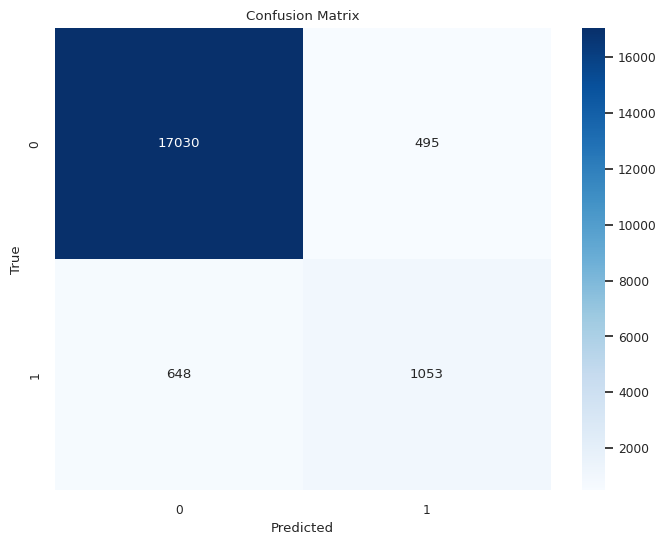

In [211]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Feature Importance

                        Feature  Importance
2                   HbA1c_level    0.437999
3           blood_glucose_level    0.321890
0                           age    0.125476
1                           BMI    0.059253
4                 gender_Female    0.028551
5                   gender_Male    0.016573
10                heart_disease    0.003219
9                  hypertension    0.002888
7    smoking_history_non-smoker    0.001789
6       smoking_history_current    0.001682
8   smoking_history_pass_smoker    0.000681


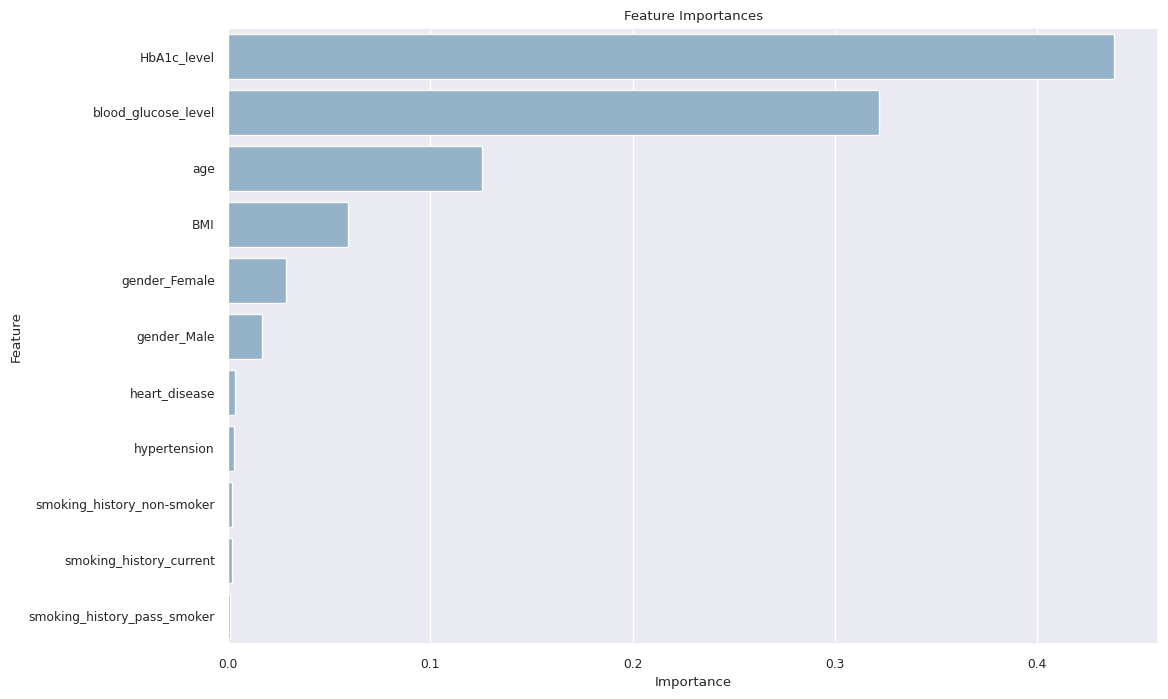

In [212]:
onehot_columns = list(
    grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(
        ['gender', 'smoking_history']))
bin_columns = ['hypertension', 'heart_disease']

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level'] + onehot_columns + bin_columns
# retrieve ['gender_Female','gender_Male', 'smoking_history_current' 'smoking_history_non-smoker', 'smoking_history_pass_smoker']

importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# The order of the numbers in importances exactly matches the order of the columns fed to the model input. The order of features is preserved automatically by Pipeline.
importances_df = pd.DataFrame({'Feature': feature_names, "Importance": importances})

importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", data=importance_df, y='Feature')
plt.title('Feature Importances')
plt.show()

## KNN

In [213]:
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', KNeighborsClassifier())
])

In [214]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2],
    'classifier__weights': ['uniform', 'distance'],
    # 'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [215]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('best parameters', grid_search.best_params_)

best parameters {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'uniform'}


## Convert GridSearchCV results to a DataFrame and plot

In [216]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__metric,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087562,0.002675,0.313295,0.007588,euclidean,3,1,uniform,"{'classifier__metric': 'euclidean', 'classifie...",0.913985,0.915090,0.917620,0.922107,0.917620,0.917284,0.002799,42
1,0.093394,0.004981,0.159861,0.003843,euclidean,3,1,distance,"{'classifier__metric': 'euclidean', 'classifie...",0.914310,0.913790,0.917165,0.917750,0.910403,0.914684,0.002639,47
2,0.090295,0.001609,0.316534,0.002004,euclidean,3,2,uniform,"{'classifier__metric': 'euclidean', 'classifie...",0.916065,0.916520,0.919116,0.922042,0.915410,0.917831,0.002453,40
3,0.092877,0.003255,0.160810,0.002043,euclidean,3,2,distance,"{'classifier__metric': 'euclidean', 'classifie...",0.911904,0.915545,0.914629,0.915475,0.910858,0.913682,0.001935,48
4,0.091463,0.003564,0.354464,0.005614,euclidean,5,1,uniform,"{'classifier__metric': 'euclidean', 'classifie...",0.921917,0.920226,0.923797,0.924902,0.924512,0.923071,0.001754,28
5,0.091225,0.002965,0.198015,0.003185,euclidean,5,1,distance,"{'classifier__metric': 'euclidean', 'classifie...",0.918081,0.918731,0.924642,0.924122,0.918726,0.920860,0.002890,32
6,0.092316,0.002739,0.360246,0.003777,euclidean,5,2,uniform,"{'classifier__metric': 'euclidean', 'classifie...",0.917236,0.920096,0.922367,0.927763,0.914694,0.920431,0.004489,33
7,0.090790,0.002372,0.195127,0.002864,euclidean,5,2,distance,"{'classifier__metric': 'euclidean', 'classifie...",0.918796,0.916065,0.922822,0.922692,0.918986,0.919872,0.002572,35
8,0.097788,0.003027,0.416036,0.011375,euclidean,7,1,uniform,"{'classifier__metric': 'euclidean', 'classifie...",0.923802,0.922892,0.926008,0.928153,0.923342,0.924839,0.001973,14
9,0.097943,0.004359,0.245626,0.006140,euclidean,7,1,distance,"{'classifier__metric': 'euclidean', 'classifie...",0.920356,0.921266,0.924772,0.926398,0.923602,0.923279,0.002221,25


## Predict and evaluate

In [217]:
y_pred = grid_search.predict(X_test)

print("Model accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model accuracy:  0.9246853219598461
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     17525
           1       0.55      0.81      0.66      1701

    accuracy                           0.92     19226
   macro avg       0.77      0.87      0.81     19226
weighted avg       0.94      0.92      0.93     19226



## Plot confusion matrix

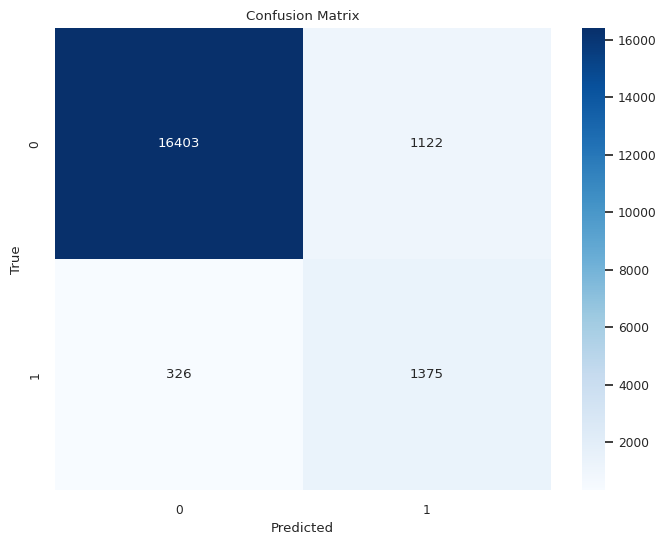

In [218]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Feature Importance

                        Feature  Importance
2                   HbA1c_level    0.042063
3           blood_glucose_level    0.037969
0                           age    0.004775
5                   gender_Male    0.000765
1                           BMI    0.000198
8   smoking_history_pass_smoker   -0.000676
4                 gender_Female   -0.001155
6       smoking_history_current   -0.002200
7    smoking_history_non-smoker   -0.002200
10                heart_disease   -0.002330
9                  hypertension   -0.003012


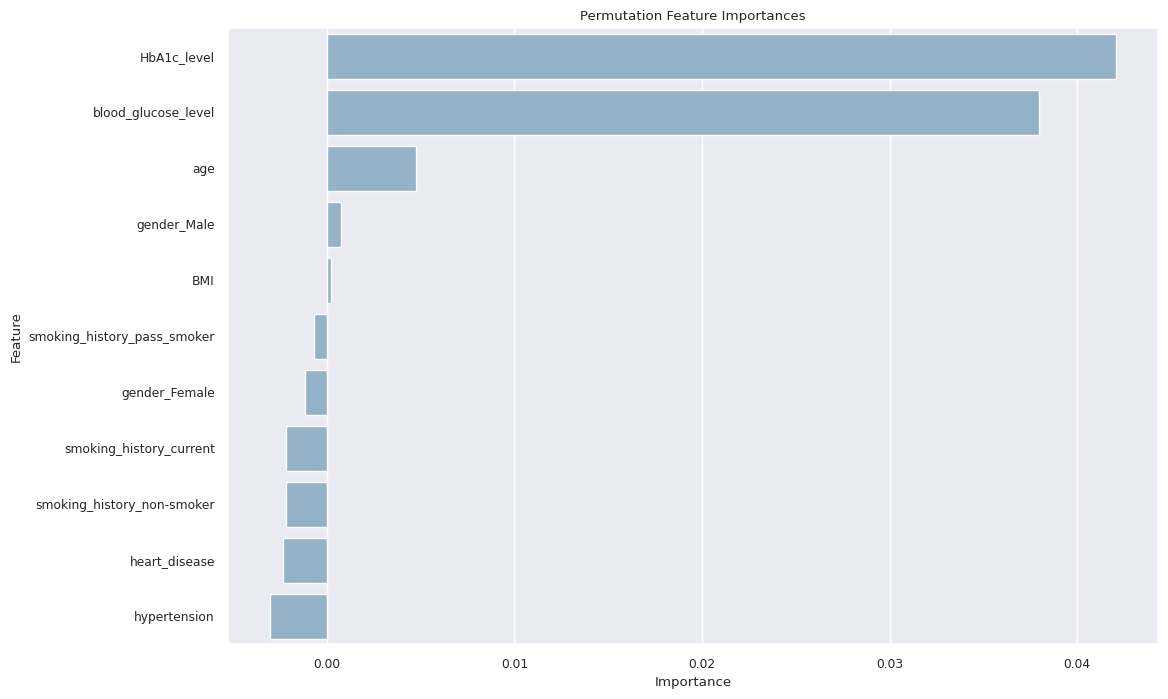

In [219]:
# todo. figure out
X_test_transformed = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

classifier = grid_search.best_estimator_.named_steps['classifier']

result = permutation_importance(
    classifier,
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Permutation Feature Importances')
plt.show()

## LR

In [220]:
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', LogisticRegression())
])

In [131]:
# param_grid = {
#     'classifier__C': [0.01, 0.1, 1, 10, 100],
#     # A smaller value of C means strong regularization (the model will be simpler and will overfit less). A larger value of C means weak regularization (the model may become complex and overfit).
#     'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
#     # Specifies which algorithm will be used to find the optimal model coefficients.
#     # liblinear: used for small datasets and supports L1 regularization.
#     # lbfgs: efficient for large datasets, supports L2 regularization.
#     # saga: suitable for large datasets, supports both L1 and L2 regularization.
#     'classifier__penalty': ['l1', 'l2'],
#     # Determines the type of regularization the model will use.
#     # l1: L1 regularization (greatly reduces some coefficients to zero, creating a sparser model).
#     # l2: L2 regularization (reduces the influence of all coefficients, but they do not become zero).
#     'classifier__max_iter': [100, 200, 300]  # Number of iterations
# }

In [132]:
# grid_search = GridSearchCV(clf, param_grid, cv=5)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
# grid_search.fit(X_train, y_train)
#
# print('Best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

Best parameters {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimat

In [221]:
# todo. figure out
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    # A smaller value of C means strong regularization (the model will be simpler and will overfit less). A larger value of C means weak regularization (the model may become complex and overfit).
    'classifier__solver': ['liblinear', 'saga'],
    # Specifies which algorithm will be used to find the optimal model coefficients.
    # liblinear: used for small datasets and supports L1 regularization.
    # lbfgs: efficient for large datasets, supports L2 regularization.
    # saga: suitable for large datasets, supports both L1 and L2 regularization.
    'classifier__penalty': ['l1', 'l2'],
    # Determines the type of regularization the model will use.
    # l1: L1 regularization (greatly reduces some coefficients to zero, creating a sparser model).
    # l2: L2 regularization (reduces the influence of all coefficients, but they do not become zero).
    'classifier__max_iter': [300, 500, 1000]  # Number of iterations
}

In [222]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('Best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

Best parameters {'classifier__C': 0.01, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


## Convert GridSearchCV results to a DataFrame and plot

In [223]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.099556,0.006491,0.005794,0.000208,0.01,300,l1,liblinear,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.927313,0.926793,0.924122,0.926593,0.922562,0.925477,0.001827,49
1,0.113382,0.002230,0.005949,0.000187,0.01,300,l1,saga,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.925232,0.929523,0.926853,0.927893,0.923212,0.926543,0.002173,9
2,0.093305,0.000786,0.006155,0.000079,0.01,300,l2,liblinear,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.926988,0.926273,0.925878,0.928804,0.923407,0.926270,0.001748,19
3,0.110819,0.001763,0.005946,0.000303,0.01,300,l2,saga,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.928418,0.928938,0.929454,0.930364,0.926398,0.928714,0.001325,3
4,0.099213,0.001641,0.005972,0.000288,0.01,500,l1,liblinear,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.926143,0.927703,0.925163,0.926138,0.921847,0.925399,0.001954,52
5,0.110739,0.003402,0.006081,0.000307,0.01,500,l1,saga,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.926013,0.927768,0.926723,0.928088,0.923992,0.926517,0.001463,10
6,0.091876,0.001079,0.005925,0.000216,0.01,500,l2,liblinear,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.926533,0.925102,0.925033,0.929194,0.922562,0.925685,0.002170,42
7,0.110534,0.002105,0.005993,0.000266,0.01,500,l2,saga,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.927703,0.929003,0.931079,0.931014,0.925943,0.928949,0.001970,2
8,0.097270,0.000785,0.005762,0.000205,0.01,1000,l1,liblinear,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.924907,0.925167,0.922822,0.927633,0.920546,0.924215,0.002386,60
9,0.115507,0.003510,0.007513,0.002574,0.01,1000,l1,saga,"{'classifier__C': 0.01, 'classifier__max_iter'...",0.925492,0.929393,0.928218,0.928544,0.924837,0.927297,0.001795,4


## Predict and evaluate

In [224]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.9285862893997712
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     17525
           1       0.57      0.78      0.66      1701

    accuracy                           0.93     19226
   macro avg       0.77      0.86      0.81     19226
weighted avg       0.94      0.93      0.93     19226



## Plot confusion matrix

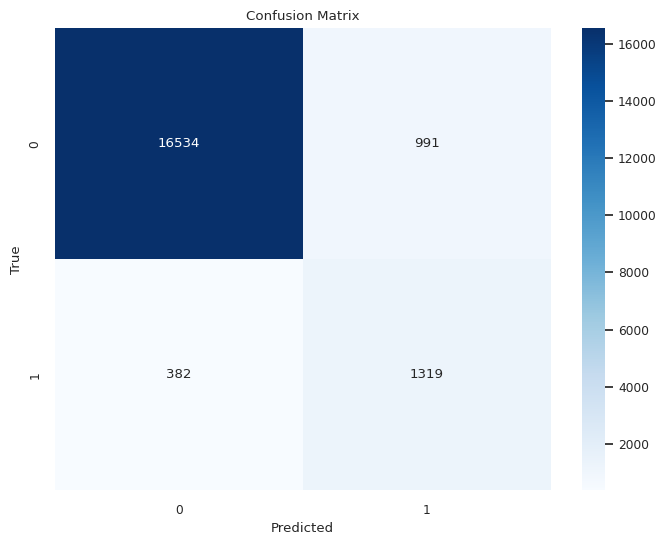

In [225]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## XGBoost

In [226]:
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', xgb.XGBClassifier()),
])

In [227]:
param_grid = {
    'classifier__max_depth': [3, 5, 7],  # Maximum tree depth
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__n_estimators': [100, 200],  # Number of trees
    'classifier__subsample': [0.8, 1.0],  # Subsample fraction for each tree
    'classifier__colsample_bytree': [0.8, 1.0],  # Feature fraction for each tree
    'classifier__objective': ['multi:softmax'],  # For multi-class classification
    'classifier__num_class': [len(set(y))]
    # 2 - because there are no diabetes, diabetes. Number of classes in the dataset
}

In [228]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("best parameters", grid_search.best_params_)

best parameters {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__num_class': 2, 'classifier__objective': 'multi:softmax', 'classifier__subsample': 0.8}


## Convert GridSearchCV results to a DataFrame and plot

In [229]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__num_class,param_classifier__objective,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.253748,0.196649,0.014843,0.004930,0.8,0.01,3,100,2,multi:softmax,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",0.971523,0.972173,0.970546,0.971131,0.970286,0.971132,0.000678,1
1,0.523820,0.326388,0.015523,0.003880,0.8,0.01,3,100,2,multi:softmax,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.971523,0.972173,0.970546,0.971131,0.970286,0.971132,0.000678,1
2,0.199416,0.016661,0.024657,0.001808,0.8,0.01,3,200,2,multi:softmax,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",0.971523,0.972173,0.970546,0.971131,0.970286,0.971132,0.000678,1
3,0.263765,0.122265,0.019917,0.004725,0.8,0.01,3,200,2,multi:softmax,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.971523,0.972173,0.970546,0.971131,0.970286,0.971132,0.000678,1
4,0.168928,0.016013,0.019989,0.004536,0.8,0.01,5,100,2,multi:softmax,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",0.953514,0.954099,0.957022,0.958453,0.954421,0.955502,0.001903,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.383819,0.121428,0.031463,0.008739,1.0,0.20,5,200,2,multi:softmax,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",0.940251,0.932189,0.938687,0.938362,0.934525,0.936803,0.002978,67
68,0.253584,0.016066,0.025880,0.005489,1.0,0.20,7,100,2,multi:softmax,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",0.939081,0.934985,0.941547,0.940507,0.939467,0.939117,0.002238,58
69,0.671217,0.863597,0.029522,0.005815,1.0,0.20,7,100,2,multi:softmax,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",0.936285,0.934335,0.940767,0.941938,0.939077,0.938480,0.002812,62
70,0.777041,0.448392,0.046725,0.009843,1.0,0.20,7,200,2,multi:softmax,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",0.930499,0.928678,0.935111,0.935111,0.932965,0.932473,0.002548,71


## Predict and evaluate

In [230]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.9692603765733901
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17525
           1       1.00      0.65      0.79      1701

    accuracy                           0.97     19226
   macro avg       0.98      0.83      0.89     19226
weighted avg       0.97      0.97      0.97     19226



## Plot confusion matrix

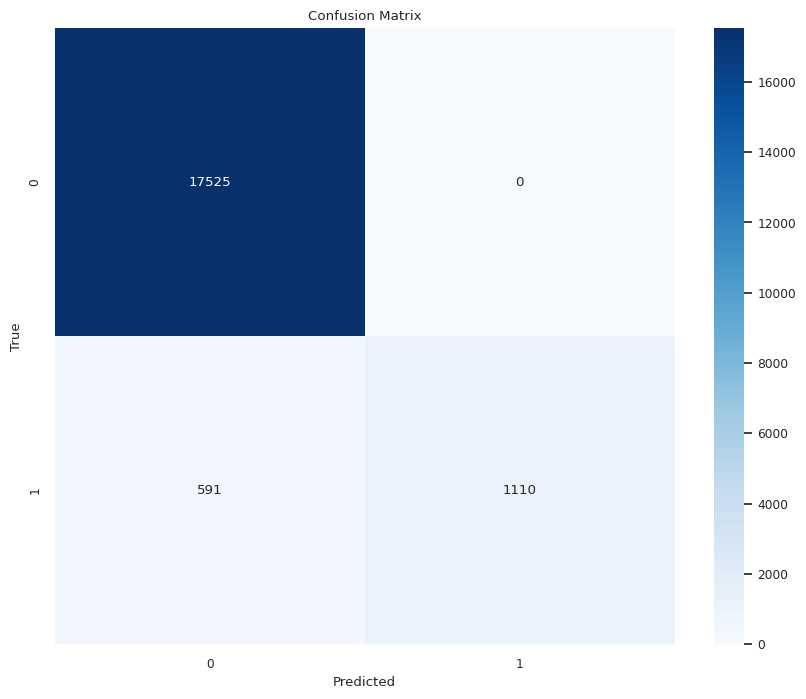

In [231]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Feature Importance

                        Feature  Importance
2                   HbA1c_level    0.723910
0                           age    0.153055
3           blood_glucose_level    0.076452
4                  hypertension    0.021497
1                           BMI    0.020658
6                 gender_Female    0.004428
5                 heart_disease    0.000000
7                   gender_Male    0.000000
8       smoking_history_current    0.000000
9    smoking_history_non-smoker    0.000000
10  smoking_history_pass_smoker    0.000000


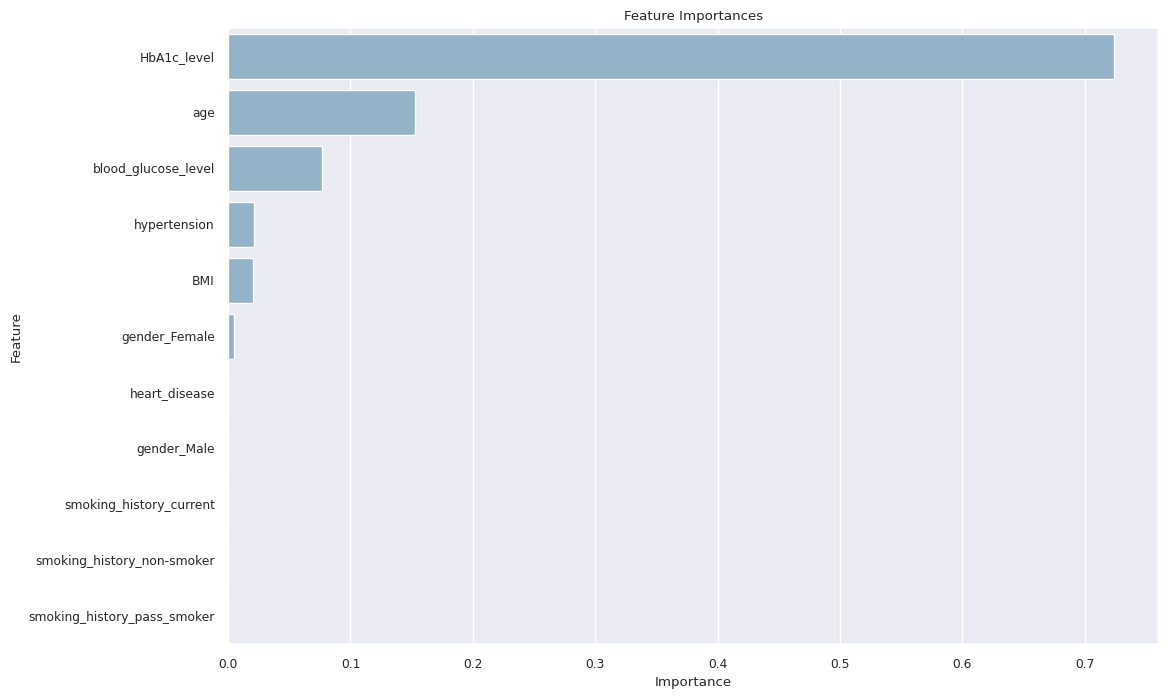

In [232]:
onehot_columns = list(
    grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(
        ['gender', 'smoking_history']))

feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

importance = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importances")
plt.show()

## Lightgbm

In [31]:
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', LGBMClassifier(verbose=-1))
])

In [36]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [15, 31],
    'classifier__min_child_samples': [10, 20, 30],
}

In [38]:
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("best parameters", grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature

best parameters {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_samples': 10, 'classifier__n_estimators': 100, 'classifier__num_leaves': 15}


In [35]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214357,0.054039,0.017795,0.004224,0.01,5,100,"{'classifier__learning_rate': 0.01, 'classifie...",0.971932,0.972557,0.972307,0.971682,0.972120,0.972120,0.000301,1
1,0.388753,0.040257,0.028273,0.005093,0.01,5,200,"{'classifier__learning_rate': 0.01, 'classifie...",0.968057,0.962368,0.969307,0.956179,0.960743,0.963331,0.004834,2
2,0.355267,0.042350,0.022796,0.003939,0.01,7,100,"{'classifier__learning_rate': 0.01, 'classifie...",0.967181,0.960555,0.964806,0.954992,0.962368,0.961980,0.004149,3
3,0.653463,0.082615,0.030712,0.003622,0.01,7,200,"{'classifier__learning_rate': 0.01, 'classifie...",0.949553,0.952804,0.954992,0.954116,0.953679,0.953029,0.001876,4
4,0.274125,0.076832,0.020640,0.002285,0.10,5,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.941489,0.947553,0.947428,0.949178,0.943489,0.945827,0.002865,5
5,0.497975,0.079107,0.035046,0.007920,0.10,5,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.937926,0.941927,0.945365,0.947928,0.940989,0.942827,0.003483,7
6,0.324966,0.020000,0.020614,0.001661,0.10,7,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.941051,0.943739,0.949303,0.946615,0.940301,0.944202,0.003382,6
7,0.584945,0.109353,0.035209,0.007725,0.10,7,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.934113,0.943489,0.943427,0.945302,0.940051,0.941276,0.003964,8


## Predict and evaluate

In [39]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.9708456268440266
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18222
           1       1.00      0.67      0.80      1775

    accuracy                           0.97     19997
   macro avg       0.98      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Plot confusion matrix

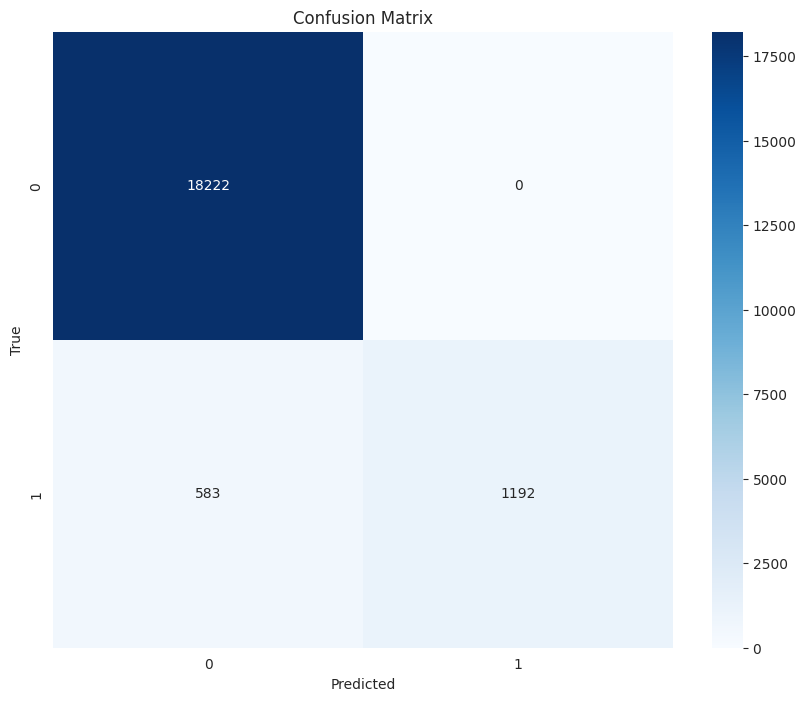

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()